# walkthrough of vine copula (vinecop) dataclasses and factory methods.

- Fitting

> obs->edge->tree->bcp->(next lv) obs

The function `tvc.vinecop.vcp_from_obs` takes multivariate copula observations (of shape $(n,d)$ and values inside $(0,1)$). By default at each level, it proposes potential edges between (pseudo)observations under proximity conditions, calculates corresponding bivariate dependency metrics to determine bicops-to-fit using modified Kruskal's maximum spanning tree (MST, Dissmann 2013), then fit bicops and calculates pseudo-obs for the next level using their `hfunc`.

This function can make `DataVineCop` following c/d/r-vine restrictions using Dissmann algo, and can use existing structure matrix to make `DataVineCop`.

When restricted to c/d-vine, this function can prioritize vertices inside `lst_first` such that they can be given by user to conduct **conditional simulation**.

- Simulation (inverse Rosenblatt transform)

The `lst_sim` attribute inside a `DataVineCop` object shows sequentially (from right to left, from shallowest to deepest) `d` pseudo-observation(on `d` levels) as source vertices to walk `d` paths until their corresponding `d` target vertices on the top level. Along each path, iteratively we do `hinv` from lower vertex to upper vertex, but may (recursively) request `hfunc` if one upper vertex is not available. C-Vine never call `hfunc`, but D-vine almost always call `hfunc`.

With `lst_first` given during fitting, the fitted `DataVineCop` object allows for **conditional simulation**, where `dct_first` can be specified for `.sim()`. In such cases, obs inside `dct_first` are taken as simulated and their paths are skipped.


In [2]:
import sys
import matplotlib.pyplot as plt
import torch

# * add proj root folder into path so `./tests` folder is searchable
sys.path.append("..")
import torchvinecopulib as tvc

# * a helper function to sim vinecop obs
from tests import sim_vcp_from_bcp

print(f"cuda (GPU) avail? {torch.cuda.is_available()}\n")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
for _ in tvc.vinecop.__all__:
    print(f"\n{_}")
    print(tvc.vinecop.__getattribute__(_).__doc__)
print(f"\nbidep func avail: {tvc.util.ENUM_FUNC_BIDEP._member_names_}")

cuda (GPU) avail? True


DataVineCop
Dataclass for a vine copula model

vcp_from_json
load a DataVineCop from a json file

    :param f_path: path to the json file, defaults to Path("./vcp.json")
    :type f_path: Path, optional
    :return: a DataVineCop object
    :rtype: DataVineCop
    

vcp_from_obs
Construct a vine copula model from multivariate observations, with structure prescribed by either Dissmann's (MST per level) method or a given matrix. May prioritize some vertices to be first in the cond simulation workflow.

    :param obs_mvcp: multivariate observations, of shape (num_obs, num_dim)
    :type obs_mvcp: torch.Tensor
    :param is_Dissmann: whether to use Dissmann's method or follow a given matrix, defaults to True; Dissmann, J., Brechmann, E. C., Czado, C., & Kurowicka, D. (2013). Selecting and estimating regular vine copulae and application to financial returns. Computational Statistics & Data Analysis, 59, 52-69.
    :type is_Dissmann: bool, optional
    :param cdrvi

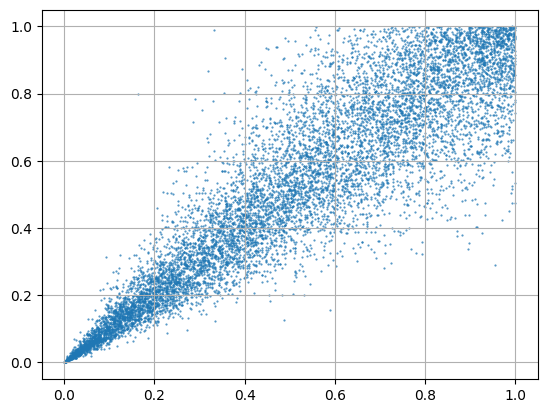

In [23]:
# simulate multivariate copula data from bicop
V_mvcp = sim_vcp_from_bcp(
    bcp_tvc=tvc.bicop.Clayton, num_sim=10000, num_dim=6, device=DEVICE
)
# visualize first two dim
plt.scatter(*V_mvcp[:, :2].T.cpu(), s=0.3, alpha=0.8)
plt.grid()

factory function


In [24]:
# make a DataVineCop object (from fitting the vinecop obs)
mdl_vcp = tvc.vinecop.vcp_from_obs(V_mvcp)
print(mdl_vcp)

{'mtd_bidep': 'kendall_tau',
 'num_dim': 6,
 'num_obs': 10_000,
 'num_par': 6,
 'negloglik': -33140.4836,
 'aic': -66268.9671,
 'bic': -66225.7051,
 'matrix': '[[ 1  4  5  2  3  0]'
           ' [-1  0  4  5  2  3]'
           ' [-1 -1  3  4  5  2]'
           ' [-1 -1 -1  2  4  5]'
           ' [-1 -1 -1 -1  4  5]'
           ' [-1 -1 -1 -1 -1  5]]',
 'lst_sim': [1, 0, 3, 2, 4, 5]}


dataclass: "draw_lv"


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Vine Copula, Level 2, BiDep Metric kendall_tau'}>)

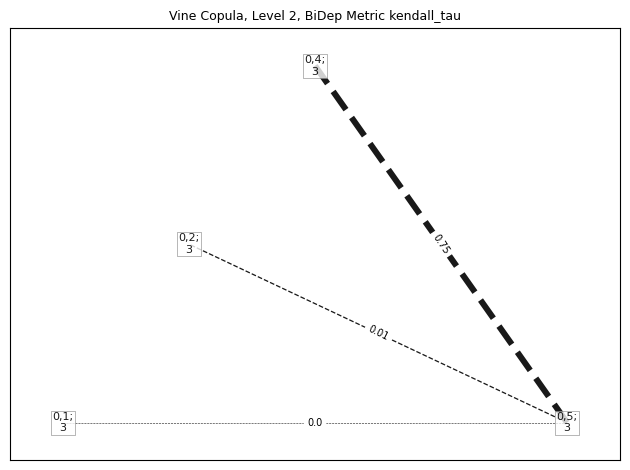

In [33]:
# for a certain level, draw the MST (of bcp) or the link between pseudo-obs
mdl_vcp.draw_lv(lv=2)

dataclass: "cdf", "l_pdf"


In [26]:
for _ in ("cdf", "l_pdf"):
    print(f"{_}\t{mdl_vcp.__getattribute__(_)(V_mvcp)}")

cdf	tensor([[0.3180],
        [0.0191],
        [0.0040],
        ...,
        [0.0461],
        [0.1182],
        [0.0296]], device='cuda:0')
l_pdf	tensor([[ 2.4368],
        [-1.4763],
        [ 1.9464],
        ...,
        [ 3.2352],
        [ 1.2063],
        [ 4.5787]], device='cuda:0', dtype=torch.float64)


IO


In [30]:
import os

file = mdl_vcp.vcp_to_json()
print(file)
print(f"json IO? {mdl_vcp == tvc.vinecop.vcp_from_json(file)}")
os.remove(file)
file = mdl_vcp.vcp_to_pkl()
print(file)
print(f"pkl IO? {mdl_vcp == tvc.vinecop.vcp_from_pkl(file)}")
os.remove(file)

vcp.json
json IO? True
vcp.pkl
pkl IO? True


draw_dag and cond sim


{'mtd_bidep': 'kendall_tau',
 'num_dim': 6,
 'num_obs': 10_000,
 'num_par': 8,
 'negloglik': -33137.2167,
 'aic': -66258.4335,
 'bic': -66200.7508,
 'matrix': '[[ 2  4  1  5  0  3]'
           ' [-1  1  4  5  0  3]'
           ' [-1 -1  4  5  0  3]'
           ' [-1 -1 -1  0  5  3]'
           ' [-1 -1 -1 -1  3  5]'
           ' [-1 -1 -1 -1 -1  5]]',
 'lst_sim': [2, 4, 1, 5, 0, 3]}


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Vine Copula, Obs and BiCop'}>)

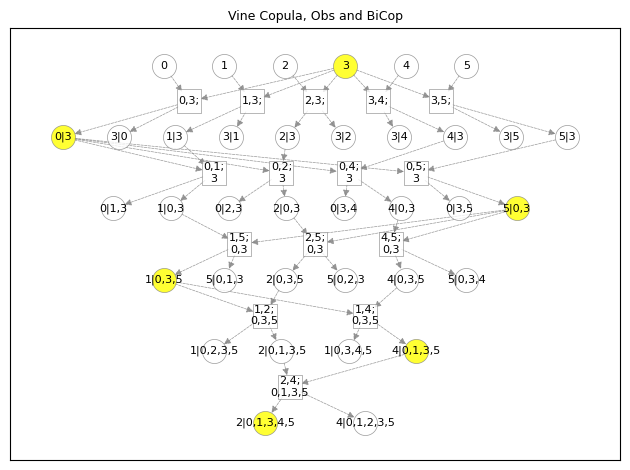

In [29]:
# give lst_first to prioritize, show the default sim workflow (source vertices highlighted)
lst_first = [3, 0]
mdl_vcp = tvc.vinecop.vcp_from_obs(V_mvcp, cdrvine="cvine", lst_first=lst_first)
print(mdl_vcp)
mdl_vcp.draw_dag()

In [36]:
mdl_vcp.sim(num_sim=10000, device=DEVICE)

tensor([[0.9433, 0.6566, 0.9006, 0.8805, 0.7516, 0.7257],
        [0.5863, 0.6621, 0.5117, 0.5778, 0.9579, 0.8912],
        [0.8836, 0.8065, 0.0341, 0.0375, 0.3818, 0.3614],
        ...,
        [0.2563, 0.2960, 0.8614, 0.9141, 0.6284, 0.8880],
        [0.4905, 0.5119, 0.6880, 0.8351, 0.9402, 0.6723],
        [0.4156, 0.4094, 0.9335, 0.8533, 0.2666, 0.3315]], device='cuda:0',
       dtype=torch.float64)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Vine Copula, Obs and BiCop'}>)

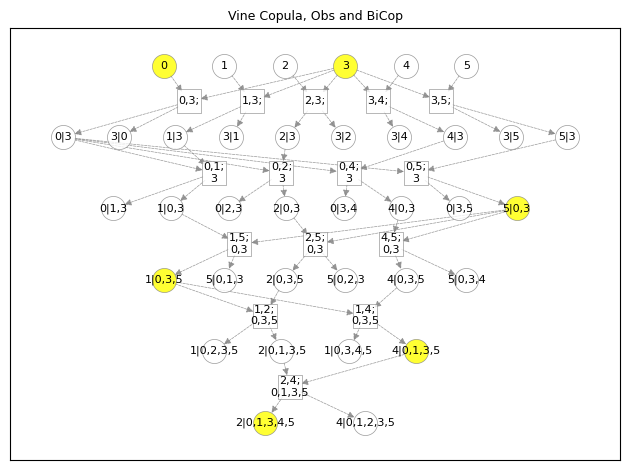

In [34]:
# show the sim workflow with lst_first taken as simulated (source vertices highlighted)
lst_first = [3, 0]
mdl_vcp.draw_dag(lst_first=lst_first)

In [48]:
num_sim = 10000
lst_obs = [0.7, 0.3]
dct_first = {
    idx: torch.ones(size=(num_sim, 1), device=DEVICE) * lst_obs[i]
    for i, idx in enumerate(lst_first)
}
for k, v in dct_first.items():
    print(k, v)

3 tensor([[0.7000],
        [0.7000],
        [0.7000],
        ...,
        [0.7000],
        [0.7000],
        [0.7000]], device='cuda:0')
0 tensor([[0.3000],
        [0.3000],
        [0.3000],
        ...,
        [0.3000],
        [0.3000],
        [0.3000]], device='cuda:0')


In [49]:
mdl_vcp.sim(num_sim=10000, dct_first=dct_first, device=DEVICE)

tensor([[0.3000, 0.4782, 0.4928, 0.7000, 0.9149, 0.8820],
        [0.3000, 0.3447, 0.7431, 0.7000, 0.6094, 0.5614],
        [0.3000, 0.3429, 0.6166, 0.7000, 0.9585, 0.8938],
        ...,
        [0.3000, 0.3081, 0.6847, 0.7000, 0.1369, 0.1712],
        [0.3000, 0.4703, 0.6111, 0.7000, 0.9152, 0.8224],
        [0.3000, 0.4590, 0.4248, 0.7000, 0.2934, 0.4062]], device='cuda:0',
       dtype=torch.float64)

timeit


In [3]:
import math
import pyvinecopulib as pvc

ctrls = pvc.FitControlsVinecop(
    family_set=[
        pvc.BicopFamily.clayton,
        pvc.BicopFamily.gumbel,
        pvc.BicopFamily.frank,
        pvc.BicopFamily.joe,
        pvc.BicopFamily.gaussian,
        pvc.BicopFamily.indep,
    ],
    parametric_method="itau",
    tree_criterion="tau",
    selection_criterion="aic",
)
lst_num_dim = [20, 40, 60, 80, 100]
for num_dim in lst_num_dim:
    num_sim = int(100 * num_dim ** (math.expm1(1)))
    print(f"\n{num_dim=}, {num_sim=}")
    V_mvcp = sim_vcp_from_bcp(bcp_tvc=tvc.bicop.Frank, num_dim=num_dim, device=DEVICE)
    mdl_vcp = tvc.vinecop.vcp_from_obs(
        V_mvcp,
        mtd_fit="itau",
        mtd_bidep="kendall_tau",
        mtd_sel="aic",
        tpl_fam=("Clayton", "Gumbel", "Frank", "Joe", "Gaussian", "Independent"),
    )
    mdl_vcp_pvc = pvc.Vinecop(data=V_mvcp.cpu(), controls=ctrls)
    %timeit mdl_vcp.sim(num_sim=num_sim, device=DEVICE)
    %timeit mdl_vcp_pvc.simulate(n=num_sim, num_threads=8)


num_dim=20, num_sim=17200
321 ms ± 7.86 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
295 ms ± 7.37 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

num_dim=40, num_sim=56596
1.03 s ± 6.41 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.66 s ± 33.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

num_dim=60, num_sim=113596
2.51 s ± 34.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
11.5 s ± 88.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

num_dim=80, num_sim=186227
6.19 s ± 26.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
41.3 s ± 181 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

num_dim=100, num_sim=273252
14.2 s ± 23.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1min 36s ± 366 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
